In [1]:
import numpy as np
import pandas as pd

# 1. Marchenko-Pastur distribution

## Application on the Spiked Model

In [ ]:
import numpy as np

def generate_spiked_covariance_vectors(n, p, sigma):
    """
    Generate n random vectors of dimension p according to the spiked covariance model.

    Parameters:
    n (int): Number of vectors to generate.
    p (int): Dimension of each vector.
    sigma (float): Scaling factor for the Gaussian noise.

    Returns:
    np.ndarray: An array of shape (n, p) containing the generated vectors.
    """
    # Fixed vector v with norm 1
    v = np.random.randn(p)
    v /= np.linalg.norm(v)

    # Initialize an array to store the vectors
    vectors = np.zeros((n, p))

    for i in range(n):
        # Generate a_i from the standard normal distribution
        a_i = np.random.randn()

        # Generate a standard random multivariate Gaussian vector
        xi = np.random.randn(p)

        # Compute the spiked covariance model vector
        vectors[i] = a_i * v + sigma * xi

    return vectors

# Example usage
n = 300  # Number of vectors
p = 50   # Dimension of each vector
sigma = 1.0  # Scaling factor for Gaussian noise

vectors = generate_spiked_covariance_vectors(n, p, sigma)
# relinquish


In [2]:
import numpy as np
import matplotlib.pyplot as plt

def generate_spiked_data(n, p, spikes):
    """
    Generate random vectors according to the spiked covariance model.

    Parameters:
    n (int): Number of samples.
    p (int): Dimension of each sample.
    spikes (list): Positions in the covariance matrix to spike.

    Returns:
    np.ndarray: Generated data of shape (n, p).
    """
    # Base covariance matrix (identity for simplicity)
    covariance_matrix = np.eye(p)

    # Introducing spikes
    for spike in spikes:
        covariance_matrix[spike, spike] *= 10  # Increasing the variance

    # Generate random vectors using multivariate normal distribution
    mean_vector = np.zeros(p)
    data = np.random.multivariate_normal(mean_vector, covariance_matrix, n)

    return data

# Parameters
n = 300  # Number of vectors
p = 50    # Dimension of each vector
spikes = [0, 1, 2]  # Spiking first three dimensions

# Generate data
data = generate_spiked_data(n, p, spikes)


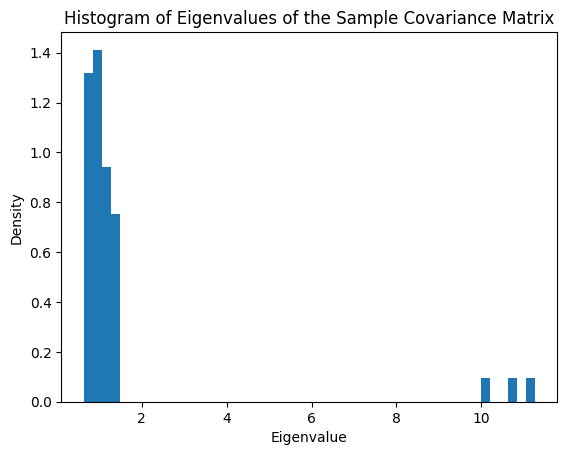

In [3]:

# Eigenvalues of the sample covariance matrix
sample_cov_matrix = np.cov(data, rowvar=False)
eigenvalues, _ = np.linalg.eigh(sample_cov_matrix)

# Plot the histogram of the eigenvalues
plt.hist(eigenvalues, bins=50, density=True)
plt.title("Histogram of Eigenvalues of the Sample Covariance Matrix")
plt.xlabel("Eigenvalue")
plt.ylabel("Density")
plt.show()